# 소프트맥스 회귀(Softmax Regression) 

* 다중 (n 개) 클래스 분류 문제에서 '독립 변수 X'가 입력되었을 때,
  각 클래스에 해당될 확률을 구하는 방법이며, n개 각각 확률의 총합은 1이 되도록 한다.
* 예로써,k개의 적성검사항목을 통해, n개 종류의 성향별 점수가 나왔고, 
  이 성향별 점수를 확률적으로 normalize하여, 어느 성향 타입인지 매칭(판별)한다.

Softmax function (소프트맥스 함수)
* 어떤 값들로 구성된 n개 행렬 원소를 받으면, 이를 normalize 하는 개념으로, 
  0~1 사이의 값으로 된 n 개의 행렬 원소로 재구성 하여 반환하는데, 원소들의 총합은 1이다.

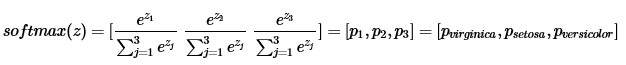

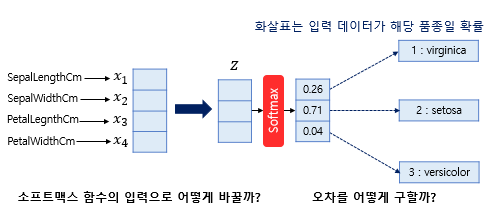

*  k차원의 독립변수 x를 'k가 아닌 다른 차원'의 class로 분류할때,  softmax function으로 입력되는 Z 값은?

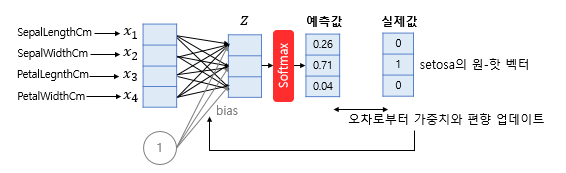

* Linear regression에서는 k개의 독립변수 x에 대해서, W는 k개, 즉 k x 1 차원이였으나,

  n개로 분류해야하는 상황에서는
  
  # W는 k x n 차원이 되어, 
  n개를 분류하는 가중치 계산을 추가로 진행한다.

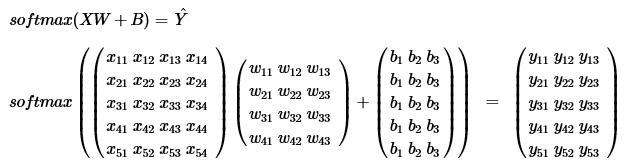

# Cost function
소프트맥스 함수의 최종 비용 함수에서 k가 2라고 가정하면 결국 로지스틱 회귀의 비용 함수와 같음.

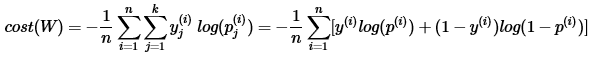

# F.cross_entropy(z, y) 함수

* entropy() input인 z는 k차원의 독립 변수 x에 가중치 w,b가 반영된 결과로 n차원임. (z1,z2, ... zn)

  class분류 정답 Y의 one-hot vector와 비교를 위해, z값들을 softmax를 통해 normalize한다.
  
  cross entropy로 cost 계산하기 위해, softmax 결과를 log 취하고, one-hot vector (class분류 정답 Y)과 계산한다.
  
  이 일련의 과정은 다음과 같이 요약 표현된다.

* 1st method (Low level)

  hypothesis = F.softmax(z, dim=1)

  y_one_hot = torch.zeros_like(hypothesis) 

  y_one_hot.scatter_(1, y.unsqueeze(1), 1)

  cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

* 위 수식의 log 함수와 softmax함수를 다음과 같이 대체가능

  torch.log(hypothesis) = torch.log(F.sofㅡtmax(z, dim=1)) = F.log_softmax(z, dim=1)


* 또한, 위 수식에서 y를 one_hot vector로 변환하는 작업을 F.nll_loss() 함수를 써서 생략가능

* 2nd method (high level)

  cost = F.nll_loss(F.log_softmax(z, dim=1), y)
  
  *(nll : Negative Log Likelihood)

* 3rd method (high level) :  F.nll_loss()와 F.log_softmax()를 포함하여, 

  cost = F.cross_entropy(z, y)
  
       = F.CrossEntropyLoss(z, y)

# 소프트맥스 회귀 구현

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [9]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

# Low level code
* cost 함수 계산을 '1st method'으로 진행
* y_train은 8x1 vector이나 3개의 class이므로, y의 one hot vector는 8 x 3이어한다. 그리고 W는 4 x 3 vector임.

In [13]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)

W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.SGD([W, b], lr=0.1)

In [14]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) 

    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


# High level code
* cost 함수 계산을 '3rd method'으로 진행
* option으로 nn.Module을 적용한 방법 추가 (# 주석 처리함)

In [16]:
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# option
# 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
# model = nn.Linear(4, 3)

optimizer = optim.SGD([W, b], lr=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    z = x_train.matmul(W) + b
    # prediction = model(x_train)
    
    cost = F.cross_entropy(z, y_train)
    # cost = F.cross_entropy(prediction, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433506
Epoch 1000/1000 Cost: 0.399962


# Advanced level code
* nn.Module을 상속받은 클래스로 구현

In [17]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3)

    def forward(self, x):
        return self.linear(x)

In [19]:
model = SoftmaxClassifierModel()

optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    prediction = model(x_train)

    cost = F.cross_entropy(prediction, y_train)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(epoch, nb_epochs, cost.item()))

Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428281
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250818


* Reference

  -.https://wikidocs.net/59425